Try chatgpt for your task before fine-tuning. If chatgpt is not enough, then fine-tune it. Do not forget that chat-gpt may be sufficient for most simple tasks.

To fine-tune the GPT-3.5 model, you need to convert each observation in your data to the following message template (Jsonline Format):

In [ ]:
# "{'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
#                {'role': 'user', 'content': 'It is a very nice pair of pants. I recommend it to everyone.'},
#                {'role': 'assistant', 'content': 'possitive'}]}"

# system: the instructions you give to the model.
# user: the feature/independent variable/text of each observation in your data (X)
# assistant: the dependent variable/target/label of each observation in your data (y).

In [1]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv("/content/drive/MyDrive/GENAI-LLM/Fıne Tuning and Function Calling/clothing_reviews.csv")
df.head()

# We will fine-tune a data set with 300 observations.

,text,label
0,"I love this shirt! great fabric, nice quality,...",positive
1,I recently purchased this tunic and love it! i...,positive
2,"I love this top, it's design is very pretty an...",positive
3,"Love this sweater! it's really flattering, lon...",positive
4,I wanted to like this so much. it's a great go...,negative


In [9]:
len(df)

300

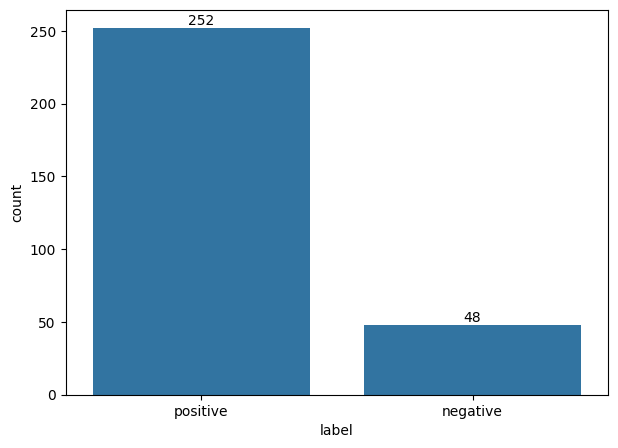

In [10]:
plt.fig = plt.figure(figsize = (7,5))
ax = sns.countplot(x="label",
                   data=df)
ax.bar_label(ax.containers[0]);

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=101)

In [13]:
print(len(X_train))
print(len(X_test))

225
75


In [14]:
X_train

283    The skirt is comfortable and as pictured. it a...
184    Saw this online and ran over to the store to t...
237    For me, this top ran true to size. i'm so glad...
230    All the colors are beautiful, the white is a t...
224    What a fun dress to wear. it feels great, and ...
                             ...                        
287    I am pleased with this skirt. the jean materia...
43     Love this top! i receive so many compliments w...
88     Received this dress yesterday, love it!\r\nmy ...
32     These jeans are very comfortable. the distress...
284    I usually wear a size xs or s in retailer tops...
Name: text, Length: 225, dtype: object

In [15]:
import json
import pandas as pd

def convert_df_to_dict(X, y):
  """Converts X and y to dictionary format.

  Args:
    X: text
    y: label

  Returns:
    A dataframe(as X and y) in dictionary format.
  """

  dictionary = []
  for i, j in zip(X, y):
    dictionary.append({
        "messages": [
            {
                "role": "system",
                "content": "Detect sentiment in the text." # system content'i tüm gözlemler için aynı olacaktır.
            },
            {
                "role": "user",
                "content": str(i)
            },
            {
                "role": "assistant",
                "content": str(j)
            }
        ]
    })

  return dictionary

# Gözlemleri JSONLine formatına dönüştürmek için öncelikle onları dict formatına dönüştürmemiz gerekiyor.

In [16]:
train = convert_df_to_dict(X_train, y_train)
test = convert_df_to_dict(X_test, y_test)

# Train ve test verilerini ayrı ayrı dictionary formatına dönüştürüyoruz.

In [17]:
train[:2]

[{'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
   {'role': 'user',
    'content': 'The skirt is comfortable and as pictured. it also ran tts. i\'m 5\'5" tall and weigh 140 lbs. i had the medium and didn\'t need to size up to a large. when you put the skirt on a normal body, it looks like you are wearing an easter egg... and not in a good way.'},
   {'role': 'assistant', 'content': 'negative'}]},
 {'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
   {'role': 'user',
    'content': "Saw this online and ran over to the store to try it on. so lovely! i thought i would want it in the cream color but the blue was so lovely in person. it's like a muted blue that makes it so versatile. the detail in the back is gorgeous and so flattering. the safety pin is such a unique touch. it's nice and warm, just not super soft, but not scratchy. i do think i will be extra careful with it because it seems like it could get caught on things easily

In [18]:
type(train[0]) # the type of observations is dict

dict

In [20]:
import json

with open("train.jsonl", "w") as f:
    for item in train:
        f.write(json.dumps(item) + "\n") # Python'da bir dictionary'i JSON formatına dönüştürmek için json.dumps() fonksiyonu kullanılır.
                                         # Bu fonksiyon dictionary'i bir JSON string'e dönüştürür.

# İnce ayar için modele besleyeceğimiz train ve test datası JSON line formatında olmalıdır. Bunun için dictionary formatındaki tüm gözlemleri
# JSON line formatına dönüştürüyoruz.

# JSON formatı dictionary formatının string'e dönüştürülmesidir.

# dict format: {'name': 'johnson', 'age':44}
# json format: "{'name': 'johnson', 'age':'44'}"


# Python uses the json.dumps() function to convert a dictionary to JSON format.
 # This function converts the dictionary into a JSON string.

# For fine tuning, the train and test data that we will feed to the model should be in JSON line format. For this, all observations in dictionary format
# We convert to JSON line format.

# JSON format is the conversion of dictionary format to string.

# dict format: {'name': 'johnson', 'age':44}
# json format: "{'name': 'johnson', 'age':'44'}"

In [21]:
with open("test.jsonl", "w") as f:
    for item in test:
        f.write(json.dumps(item) + "\n")

# Train datasına yaptığımız JSON line dönüşümünün aynısını test datasına da uyguluyoruz.

In [22]:
import json
import codecs

with codecs.open('train.jsonl', 'r', encoding='utf-8') as f:
  a = 0
  for line in f:
    print(type(line))
    print(line)
    a+=1

    if a==2:
      break

# JSON line formatına dönüştürülen tüm gözlemlerin string type'da olduğunu görebiliriz.

<class 'str'>
{"messages": [{"role": "system", "content": "Detect sentiment in the text."}, {"role": "user", "content": "The skirt is comfortable and as pictured. it also ran tts. i'm 5'5\" tall and weigh 140 lbs. i had the medium and didn't need to size up to a large. when you put the skirt on a normal body, it looks like you are wearing an easter egg... and not in a good way."}, {"role": "assistant", "content": "negative"}]}

<class 'str'>
{"messages": [{"role": "system", "content": "Detect sentiment in the text."}, {"role": "user", "content": "Saw this online and ran over to the store to try it on. so lovely! i thought i would want it in the cream color but the blue was so lovely in person. it's like a muted blue that makes it so versatile. the detail in the back is gorgeous and so flattering. the safety pin is such a unique touch. it's nice and warm, just not super soft, but not scratchy. i do think i will be extra careful with it because it seems like it could get caught on things

## Data preparation and analysis for chat model fine-tuning


**Data loading**, **Format validation**, **Token Counting Utilities**, **Data Warnings and Token Counts**, ve **Cost Estimation** bölümleri için aşağıdaki kod blokları OpenAI tarafından hazırlanmıştır. Ve ince ayardan önce kullanılması tavsiye edilir.

Bu kod blokları, bir chatgpt modeline ince ayar yapmak için kullanılan datayı önceden işlemek ve analiz etmek için bir araç görevi görür. Biçim hatalarını kontrol eder, temel istatistikler sağlar ve ince ayar maliyetini belirlemek için gerekli olan token sayılarını tahmin eder.

The following code blocks for the Data loading, Format validation, Token Counting Utilities, Data Warnings and Token Counts, and Cost Estimation sections are provided by OpenAI. And it is recommended to use them before fine tuning.

These code blocks serve as a tool to pre-process and analyze the data used to fine-tune a chatgpt model. It checks for format errors, provides basic statistics and estimates the number of tokens needed to determine the cost of fine-tuning.

In [23]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

## Data loading

We first load the chat dataset from an example JSONL file.

In [24]:
data_path = "/content/train.jsonl" # data_path değişkeni jsonl dosyasının yolunu belirtir.

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f: # with open() dosyayı açar ve json.loads() işlevini
                                                  # kullanarak her satırı bir dict nesnesi olarak yükler.

    dataset = [json.loads(line) for line in f] # tüm dict nesnelerini dataset listesine atıyoruz.

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(type(message))
    print(message)

Num examples: 225
First example:
<class 'dict'>
{'role': 'system', 'content': 'Detect sentiment in the text.'}
<class 'dict'>
{'role': 'user', 'content': 'The skirt is comfortable and as pictured. it also ran tts. i\'m 5\'5" tall and weigh 140 lbs. i had the medium and didn\'t need to size up to a large. when you put the skirt on a normal body, it looks like you are wearing an easter egg... and not in a good way.'}
<class 'dict'>
{'role': 'assistant', 'content': 'negative'}


## Format validation

Veri kümesindeki her bir gözlemin ince ayar API'sinin beklediği formata uygun olduğunu doğrulamak için çeşitli hata kontrolleri gerçekleştirebiliriz. Hatalar, daha kolay hata ayıklama için niteliklerine göre kategorize edilir.

1.**Data Type Check(Veri Tipi Kontrolü)**:Veri setindeki her girdinin(input) bir dict olup olmadığını kontrol eder. Error type: data_type.

2.**Presence of Message List(Mesaj Listesinin Varlığı)**: Her girdi için mesaj listesinin olup olmadığını kontrol eder. Error type: missing_messages_list.

3.**Message Keys Check(Mesaj Anahtarları Kontrolü)**: Mesajların içerisindeki "role" ve "content" anahtarlarının varlığını kontrol eder. Error type: message_missing_key.

4.**Unrecognized Keys in Messages(Mesajlardaki Tanınmayan Anahtarlar)**: Bir mesajın "role", "content" ve role_name(system, user, assistant) dışında anahtarları olup olmadığını kontrol eder. Error type: message_unrecognized_key.

5.**Role Validation(role doğrulaması)**: "Role"lerin "system", "user", veya "assistant" olduğunu teyit eder. Error type: unrecognized_role.

6.**Content Validation(content doğrulaması)**: contentin string bir ifade olduğunu teyit eder. Error type: missing_content.

7.**Assistant Message Presence(Asistan Mesajı Varlığı:)**: mesajın içinde assistant'a ait bir içerik olup olmadığını kontrol eder. Error type: example_missing_assistant_message.

Aşağıdaki kod, bu kontrolleri gerçekleştirir ve bulunan her türlü hatanın sayısını yazdırır. Bu, hata ayıklama ve veri kümesinin bir sonraki adımlara hazır olup olmadığını kontrol etme açısından faydalıdır.

We can perform various error checks to verify that each observation in the dataset conforms to the format expected by the fine-tuning API. Errors are categorized according to their nature for easier debugging.

1.Data Type Check: Checks whether each input in the dataset is a dict. Error type: data_type.

2.Presence of Message List: Checks if there is a message list for each input. Error type: missing_messages_list.

3.Message Keys Check: Checks for the presence of "role" and "content" keys in the messages. Error type: message_missing_key.

4.Unrecognized Keys in Messages: Checks if a message has keys other than "role", "content" and role_name(system, user, assistant). Error type: message_unrecognized_key.

5.Role Validation: Confirms that the "roles" are "system", "user", or "assistant". Error type: unrecognized_role.

6.Content Validation: verifies that the content is a string expression. Error type: missing_content.

7.Assistant Message Presence: checks if the message contains content belonging to the assistant. Error type: example_missing_assistant_message.


The code below performs these checks and prints the number of any errors found. This is useful for debugging and checking that the dataset is ready for the next steps.

In [25]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

# bu fonksiyon, verilerin ince ayar için hazır olup olmadığını kontrol eder. Eksik veya geçersiz veriler için hata döndürür.
# datada problem yoksa "Hata bulunamadı" mesajını döndürür.

No errors found


## Token Counting Utilities

Lets define a few helpful utilities to be used in the rest of the notebook.

In [26]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.05)}, {np.quantile(values, 0.95)}")

## Data Warnings and Token Counts

Aşağıdaki analizlerle, verilerdeki potansiyel sorunları, eksik mesajları belirleyebilir ve mesaj ve token sayıları hakkında istatistiksel bilgiler sağlayabiliriz.

1.**Missing System/User Messages**: "system" veya "user" mesajı eksik olan gözlemleri sayar. Bu mesajlar, assistant'ın davranışını tanımlamak ve konuşmayı başlatmak için kritik öneme sahiptir.

2.**Number of Messages Per Example**: Her bir gözlemdeki mesaj (system, user, assistant) sayısının dağılımını özetler ve diyalog karmaşıklığı hakkında bilgi sağlar. Her mesajın 3 ayrı bölümü olup olmadığını kontrol eder: system, user, assistant. Öyleyse, her mesajdaki parça sayısının min, max, mean, median, %5 ve %95 dilimlerdeki değeri her zaman 3 olacaktır. Aksi takdirde, bu değerler 3'ten farklı olacaktır.

3.**Total Tokens Per Example**: Her gözlemdeki toplam token sayısının dağılımını hesaplar ve özetler. İnce ayar maliyetlerini anlamak için önemlidir. Bu, system, user ve assistant parçaları da dahil olmak üzere her mesajdaki toplam token sayısı ve dağılımları (mean, median, minimum, maximum, etc.) hakkında bilgi sağlar.

4.**Tokens in Assistant's Messages**: her gözlemdeki assistant mesajlarındaki toekn sayısını hesaplar ve bu dağılımı özetler (mean, median, minimum, maximum, etc.). Assistant hakkında bilgi sağlar.

5.**Token Limit Warnings**:  Herhangi bir gözlem maksimum toekn sınırını (4096 token) aşarsa kontrol eder, çünkü bu tür gözlemler ince ayar sırasında kırpılacak ve bu da veri kaybına neden olacaktır.

With the following analyses, we can identify potential problems in the data, missing messages and provide statistical information about the number of messages and tokens.

1.Missing System/User Messages: Counts observations with missing "system" or "user" messages. These messages are critical for identifying the assistant's behavior and initiating the conversation.

2.Number of Messages Per Example: Summarizes the distribution of the number of messages (system, user, assistant) in each observation and provides information about the dialog complexity. It checks if each message has 3 separate parts: system, user, assistant. If so, the min, max, mean, median, 5% and 95% of the number of parts in each message will always be 3. Otherwise, these values will be different from 3.

3.Total Tokens Per Example: Calculates and summarizes the distribution of the total number of tokens in each observation. It is important to understand the fine-tuning costs. This provides information about the total number of tokens and their distribution (mean, median, minimum, maximum, etc.) in each message, including the system, user and assistant parts.

4.Tokens in Assistant's Messages: calculates the number of tokens in assistant's messages in each observation and summarizes this distribution (mean, median, minimum, maximum, etc.). Provides information about the assistant.

5.Token Limit Warnings: Checks if any observation exceeds the maximum token limit (4096 tokens), because such observations will be clipped during fine-tuning, resulting in data loss.

In [27]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 34, 166
mean / median: 97.36, 94.0
p5 / p95: 45.2, 145.79999999999998

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


NOT: Test verileri için Veri yükleme, Format doğrulama, Jeton Sayım Yardımcı Programları, Veri Uyarıları ve Jeton Sayımları bölümlerinin de yapılması gerekir. Not defterini kısa tutmak için bunu sadece eğitim verileri için yaptık.


NOTE: For test data, the Data loading, Format validation, Token Counting Utilities, Data Alerts and Token Counts sections also need to be done. To keep the notebook short, we have done this only for training data.
Ancak maliyet tahmini bölümü yalnızca eğitim verileri için yapılır.

## Cost Estimation

Bu son bölümde, ince ayar için kullanılacak toplam token sayısını tahmin ediyoruz, bu da maliyeti yaklaşık olarak tahmin etmemizi sağlıyor. Token sayısı arttıkça ince ayar işlemlerinin süresinin de artacağını belirtmekte fayda var.

In this last section, we estimate the total number of tokens that will be used for fine-tuning, which allows us to approximate the cost. It is worth noting that as the number of tokens increases, the duration of the fine-tuning process will also increase.

In [28]:
100//30

3

In [30]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:  # train datasındaki gözlem sayısı ile TARGET_EPOCHS(3) çarpımı MIN_TARGET_EXAMPLES(100)'den küçükse,
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples) # epoch olarak MAX_DEFAULT_EPOCHS(25) veya 100//(train datasındaki gözlem sayısı)'den hangisi küçükse
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES: # train datasındaki gözlem sayısı ile TARGET_EPOCHS(3) çarpımı MAX_TARGET_EXAMPLES(25000)'den büyükse,
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples) # epoch olarak MIN_DEFAULT_EPOCHS(1) veya MIN_TARGET_EXAMPLES(25000)//(train datasındaki gözlem sayısı)'den hangisi büyükse

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens) # bir yorumun token sayısı max 4096'yı geçmeyecek şekilde tüm yorumların toplam token sayısı
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens") # eğitime tabii tutulan toplam token sayısı

current_price=8 # bir milyon token başına fiyat, lütfen güncel fiyat için openai web sayfasını kontrol edin.
print(f"Estimate total costs ~{(n_epochs * n_billing_tokens_in_dataset)/1000000 * current_price}")

# İnce ayar için modele en az 10 gözlem verilmelidir. Aksi takdirde model hata döndürecektir. Ancak ince ayar için modele minimum 100, maksimum 25000
# gözlem verilmesi tavsiye edilir.

# GPT 3.5-Turbo modeli, ince ayar için varsayılan olarak 3 epoch ile çalışır. Ancak bu kod, verilerinizdeki gözlem sayısına göre minimum 1'den maksimum 25'e
# kadar kaç epoch eğitim yapmanız gerektiğini size önerir.

# Tüm eğitim boyunca işlenecek token sayısını ve bu token sayısına göre ince ayar maliyetini döndürür.

# NOT: Bu bölüm yalnızca eğitim verilerine uygulanacaktır.


# At least 10 observations must be given to the model for fine tuning. Otherwise the model will return an error. However, for fine tuning, the model should be given a minimum of 100 and a maximum of 25000
# observation is recommended.

# GPT 3.5-Turbo model works with 3 epochs by default for fine tuning. However, this code can be adjusted from a minimum of 1 to a maximum of 25, depending on the number of observations in your data.
# Suggests how many epochs of training you need to do.

# Returns the number of tokens to process over the entire training and the cost of fine-tuning based on this number of tokens.

# NOTE: This section will only apply to training data.

Dataset has ~21906 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~65718 tokens
Estimate total costs ~0.525744


In [31]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY']=userdata.get('openai_key')

In [32]:
from openai import OpenAI

client = OpenAI()
#api_key=os.environ['OPENAI_API_KEY']

In [33]:
training_response = client.files.create(file=open("/content/train.jsonl", "rb"),
                                        purpose="fine-tune") # Train datasını ince ayar için hazırlıyoruz.

training_file_id = training_response.id # Hazır olan train datası için oluşturulan ID’yi çekiyoruz.

validation_response = client.files.create(file=open("/content/test.jsonl", "rb"),
                                          purpose="fine-tune") # Test datasını ince ayar için hazırlıyoruz.

validation_file_id = validation_response.id # Hazır olan test datası için oluşturulan ID’yi çekiyoruz.

print("Training file id:", training_file_id)
print("Validation file id:", validation_file_id)

Training file id: file-Ff3jrpMZovt0ydTK0Evh1r05
Validation file id: file-sbowLb2wia7VFyeS8JNTG2sL


In [34]:
suffix_name = "sentiment analys 4"

response = client.fine_tuning.jobs.create(
    training_file=training_file_id, # Train datsının ID'si ince ayar modeline veriliyor. Train datasının ID'si mutlaka sağlanmalıdır
    validation_file=validation_file_id, #Validation datsının ID'si ince ayar modeline veriliyor. Bu kimliği sağlamak isteğe bağlıdır
    model="gpt-3.5-turbo", # şimdilik mevcut tek model GPT-3.5-turbo'dur. GPT-4'ün yakın gelecekte kullanıma sunulmasını bekliyoruz.
    suffix=suffix_name, # İnce ayar yapılan modelin ismine kendi seçeceğimiz bir ek ekleyebiliyoruz ancak modelin ismini tam olarak belirleyemiyoruz.
    hyperparameters={"n_epochs":3}, # Yalnızca Epoch, batchsize ve learning_rate_multiplier parametresini ayarlamamıza izin veriliyor.
                                    # Önerilen epoch sayısı 3 olduğundan epoch'u 3 olarak ayarladık.
)

job_id = response.id # The ID of fine-tune model.

print(response)

FineTuningJob(id='ftjob-8QePFrG4ictRCjm2F8kOP3K9', created_at=1720723853, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-2DK8uJ3r4XlwyMWXFl6PyYe2', result_files=[], seed=1718430282, status='validating_files', trained_tokens=None, training_file='file-Ff3jrpMZovt0ydTK0Evh1r05', validation_file='file-sbowLb2wia7VFyeS8JNTG2sL', estimated_finish=None, integrations=[], user_provided_suffix='sentiment analys 4')


In [35]:
job_id

'ftjob-8QePFrG4ictRCjm2F8kOP3K9'

In [ ]:
#client.fine_tuning.jobs.retrieve(job_id) # status='validating_files', status="running"

FineTuningJob(id='ftjob-0hfuuPKC1PCqlnosHBZTCKfG', created_at=1720523850, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-b88r78OSLP9wnPnDMsswFKhJ', result_files=[], seed=1878058037, status='running', trained_tokens=None, training_file='file-Csb5pwN5aD6J6770lFi0JyOL', validation_file='file-xDzh9gWL2vxqkD7Dr4VmoTDz', estimated_finish=1720525751, integrations=[], user_provided_suffix='sentiment analys 4')

In [36]:
client.fine_tuning.jobs.retrieve(job_id) # İnce ayar hakkında genel bilgiler alıyoruz.

FineTuningJob(id='ftjob-8QePFrG4ictRCjm2F8kOP3K9', created_at=1720723853, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-2DK8uJ3r4XlwyMWXFl6PyYe2', result_files=[], seed=1718430282, status='validating_files', trained_tokens=None, training_file='file-Ff3jrpMZovt0ydTK0Evh1r05', validation_file='file-sbowLb2wia7VFyeS8JNTG2sL', estimated_finish=None, integrations=[], user_provided_suffix='sentiment analys 4')

In [37]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=50) # Son 10 adımdaki ince ayar işleminin olaylarını görüntüler.

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-us3JIopt2GQ7sOhH6yLYvcDz', created_at=1720723853, level='info', message='Validating training file: file-Ff3jrpMZovt0ydTK0Evh1r05 and validation file: file-sbowLb2wia7VFyeS8JNTG2sL', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-uncLPj33av7DcUR7imvaKrdg', created_at=1720723853, level='info', message='Created fine-tuning job: ftjob-8QePFrG4ictRCjm2F8kOP3K9', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)

In [38]:
response= client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id)

events=response.data

In [39]:
events.reverse()# İnce ayar işleminin ilk adımları başlangıçta olacak şekilde, reverse() fonksiyonunu kullanarak
                # ince ayar adımlarının sırasını tersine çeviriyoruz.

In [40]:
events

[FineTuningJobEvent(id='ftevent-uncLPj33av7DcUR7imvaKrdg', created_at=1720723853, level='info', message='Created fine-tuning job: ftjob-8QePFrG4ictRCjm2F8kOP3K9', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-us3JIopt2GQ7sOhH6yLYvcDz', created_at=1720723853, level='info', message='Validating training file: file-Ff3jrpMZovt0ydTK0Evh1r05 and validation file: file-sbowLb2wia7VFyeS8JNTG2sL', object='fine_tuning.job.event', data={}, type='message')]

In [41]:
for event in events:
    print(event.message) #

Created fine-tuning job: ftjob-8QePFrG4ictRCjm2F8kOP3K9
Validating training file: file-Ff3jrpMZovt0ydTK0Evh1r05 and validation file: file-sbowLb2wia7VFyeS8JNTG2sL


In [ ]:
#client.fine_tuning.jobs.cancel(job_id)

# You can cancel the fine-tuning process you have started with this code. However, the fine-tuning process will start in 1-2 minutes,
# so you need to cancel it before that. If you don't, you won't be able to cancel it.

In [42]:
import numpy as np
np.exp(-0.14)

0.8693582353988059

In [43]:
np.log(0.8693582353988059)

-0.13999999999999996

## Prediction

In [44]:
client.fine_tuning.jobs.retrieve(job_id) # İnce ayar hakkında genel bilgiler alıyoruz öncelikle. burdan fine-tune model ismini çekeceğiz

FineTuningJob(id='ftjob-8QePFrG4ictRCjm2F8kOP3K9', created_at=1720723853, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-2DK8uJ3r4XlwyMWXFl6PyYe2', result_files=[], seed=1718430282, status='running', trained_tokens=None, training_file='file-Ff3jrpMZovt0ydTK0Evh1r05', validation_file='file-sbowLb2wia7VFyeS8JNTG2sL', estimated_finish=None, integrations=[], user_provided_suffix='sentiment analys 4')

In [45]:
model_name= client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model # model ismini çekiyoruz.
model_name

In [49]:
# Retrieve the job details
job = client.fine_tuning.jobs.retrieve(job_id)

# Check if the job has a fine-tuned model associated with it
if job.fine_tuned_model:
    model_name = job.fine_tuned_model
    print("Using fine-tuned model:", model_name)
else:
    # Handle the case where the job doesn't have a fine-tuned model
    # You might want to use a default model or raise an error
    model_name = "gpt-3.5-turbo"  # Replace with a suitable default model
    print("No fine-tuned model found, using default model:", model_name)

No fine-tuned model found, using default model: gpt-3.5-turbo


In [51]:
system="Detect sentiment in a text." # Tahmin için kullanacağımız system içeriği, ince ayar için kullandığımız system içeriğiyle aynıdır.

In [52]:
# Test verilerinden birkaç gözlem seçip tahminlerde bulunalım.
display(X_test.loc[139])
display(y_test.loc[139])

'I love this dress! it\'s so comfy and flowy. i wore to an event and got many compliments on the color and design of the dress. i\'m 5\'5" and weigh 150.'

'positive'

In [53]:
completion = client.chat.completions.create(
  model=model_name,
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": X_test.loc[139]}
  ]
)

print(completion.choices[0].message.content)

The sentiment in the text is positive.


In [54]:
display(X_test.loc[85])
display(y_test.loc[85])

'When i saw this blouse online i thought it looked like a great combination of casual with the elegance of an intricate print. i was so disappointed when it came. the print is not centered in the front or the back. it looks like they were trying to save on the material and just cut it out wherever with no thought to symmetry. for this price the detail of centering the design was expected, especially because this is how it appeared in the picture. loved the blouse, but i will be returning it becau'

'negative'

In [55]:
completion = client.chat.completions.create(
  model=model_name,
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": X_test.loc[85]}
  ]
)

print(completion.choices[0].message.content)

The sentiment in the text is mostly negative. The person expresses disappointment in the product they received, stating that the print is not centered as expected and they feel like the design was not taken care of properly. They mention that they will be returning the blouse.
